In [4]:
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2025-08-24 11:37:25.694188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756015645.844579   13407 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756015645.885081   13407 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756015646.141244   13407 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756015646.141396   13407 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756015646.141400   13407 computation_placer.cc:177] computation placer alr

In [10]:
model = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(400, 400, 3),  # FIXED: 400x400 like notebook
                                  weights='imagenet')

In [11]:
model.trainable = False
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2), 
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)
]

In [12]:
def get_layer_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

content_layer = [('block5_conv4', 1)]
vgg_model_outputs = get_layer_outputs(model, STYLE_LAYERS + content_layer)

In [13]:
# FIXED: Removed the poisonous /255.0 line completely
def gram_matrices_vectorized(a_a):  
    b , i , j , k =  a_a.shape[0] , a_a.shape[1] , a_a.shape[2] , a_a.shape[3]  
    # REMOVED: a_a = a_a / 255.0  # ❌ THIS POISON LINE IS GONE
    grahm_matrix = tf.zeros([b,k,k])
    X = tf.reshape(a_a , (b,i*j,k))    
    grahm_matrix= tf.matmul(X,X,transpose_a = True)
    return grahm_matrix

In [14]:
def style_cost(G_s, G_g, a_s):
    batch_size, n_h, n_w, n_c = a_s.shape[0], a_s.shape[1], a_s.shape[2], a_s.shape[3]
    
    sub = tf.reduce_sum(tf.square(tf.subtract(G_s, G_g)))
    norm = 4.0 * tf.cast(n_h * n_w, tf.float32) * tf.cast(n_c * n_c, tf.float32)
    
    result = tf.divide(sub, norm)
    return result

def content_cost(a_c, a_g_c):
    cost = 0.5 * tf.reduce_mean(tf.square(a_c - a_g_c))
    return cost

def total_variation_loss(img):
    x_deltas = img[:, :, 1:, :] - img[:, :, :-1, :]
    y_deltas = img[:, 1:, :, :] - img[:, :-1, :, :]
    return tf.reduce_mean(tf.abs(x_deltas)) + tf.reduce_mean(tf.abs(y_deltas))

In [15]:
def total_loss(a_c, a_s, a_g_s, a_g_c, alpha=0.1, beta=0.1):
    G_s = gram_matrices_vectorized(a_s)  
    G_g = gram_matrices_vectorized(a_g_s)  
    style = style_cost(G_s, G_g, a_s)
    content = content_cost(a_c, a_g_c)
    total_cost = alpha * content + beta * style
    return total_cost

In [23]:

dim = 400  

# After loading images, convert to float32
img1 = tf.keras.utils.load_img("style.jpg", target_size=(dim,dim))
img1 = tf.keras.utils.img_to_array(img1)
img1 = tf.expand_dims(img1, axis=0)
img1 = tf.cast(img1, tf.float32)
styleImg = tf.keras.applications.vgg19.preprocess_input(img1)

img2 = tf.keras.utils.load_img("ocean.png", target_size=(dim,dim))
img2 = tf.keras.utils.img_to_array(img2)
img2 = tf.expand_dims(img2, axis=0)
img2 = tf.cast(img2, tf.float32)
contentImg = tf.keras.applications.vgg19.preprocess_input(img2)

generatedImg = tf.Variable(contentImg, trainable=True)

In [24]:
def generated_to_display(generated_tensor):
    img = generated_tensor.numpy() * 255
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def vgg_to_display(vgg_tensor):
    img = vgg_tensor.numpy()
    img = img + [103.939, 116.779, 123.68]
    img = img[..., ::-1]
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

mkdir: cannot create directory ‘save_here6’: File exists


/mnt/windows/Users/Admin/Desktop/CondaLinux/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_22']
Received: inputs=Tensor(shape=(1, 400, 400, 3))
  warnings.warn(msg)



Iteration 0:
Total loss: 1.26e+12
  Content loss: 3.12e+01
  Style loss: 1.26e+13
  TV loss: 8.12e+01
  Generated img range: [-103.939, 131.320]
  Display img stats: Min=0, Max=255
  Mean RGB: [ 70.88090625 110.5753     143.66218125]


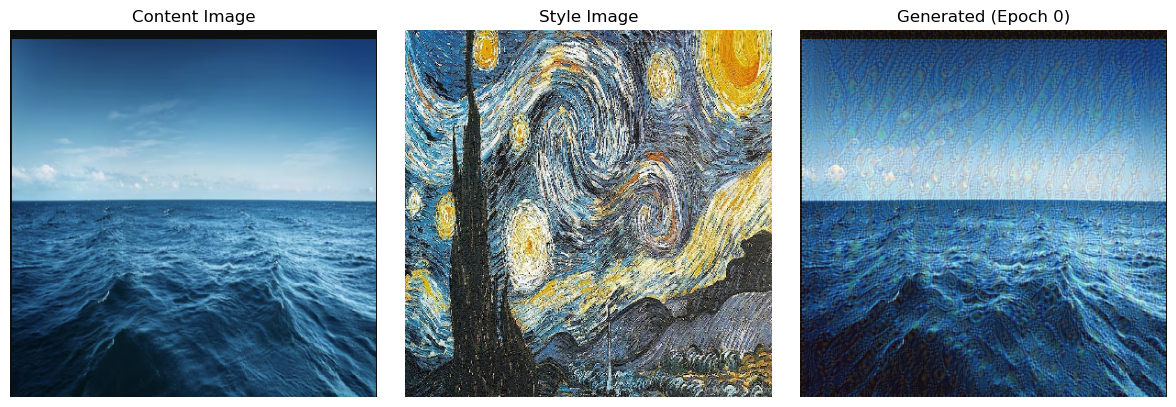


Iteration 1000:
Total loss: 2.55e+11
  Content loss: 3.04e+01
  Style loss: 2.55e+12
  TV loss: 1.19e+02
  Generated img range: [-103.939, 131.320]
  Display img stats: Min=0, Max=255
  Mean RGB: [ 74.3826875  110.56125625 142.078275  ]


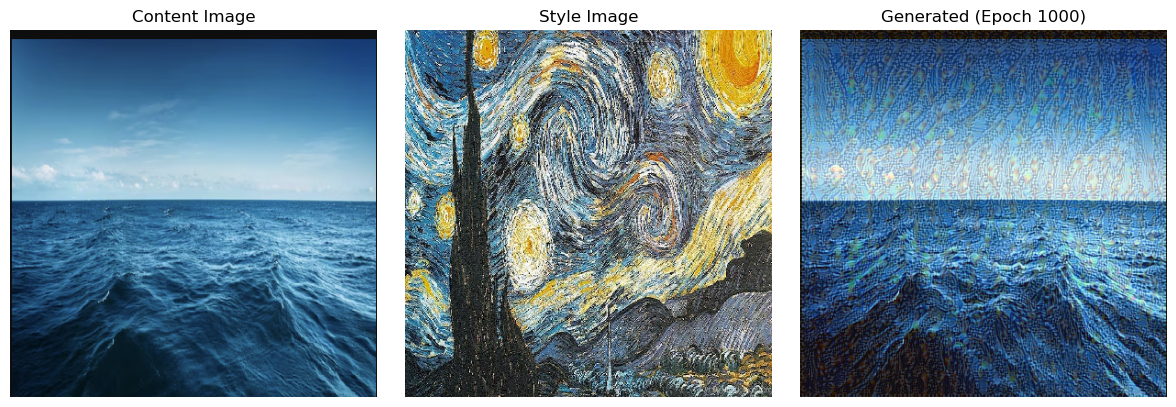


Iteration 2000:
Total loss: 1.24e+11
  Content loss: 2.93e+01
  Style loss: 1.24e+12
  TV loss: 1.40e+02
  Generated img range: [-103.939, 131.320]
  Display img stats: Min=0, Max=255
  Mean RGB: [ 77.2790625  111.39319375 139.6094625 ]


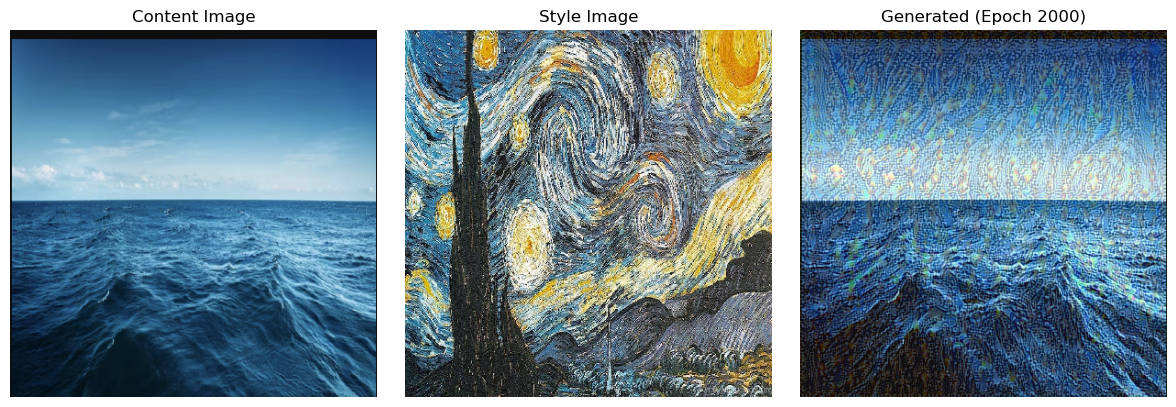


Iteration 3000:
Total loss: 7.00e+10
  Content loss: 2.92e+01
  Style loss: 7.00e+11
  TV loss: 1.55e+02
  Generated img range: [-103.939, 131.320]
  Display img stats: Min=0, Max=255
  Mean RGB: [ 80.8891375 112.35045   135.8861125]


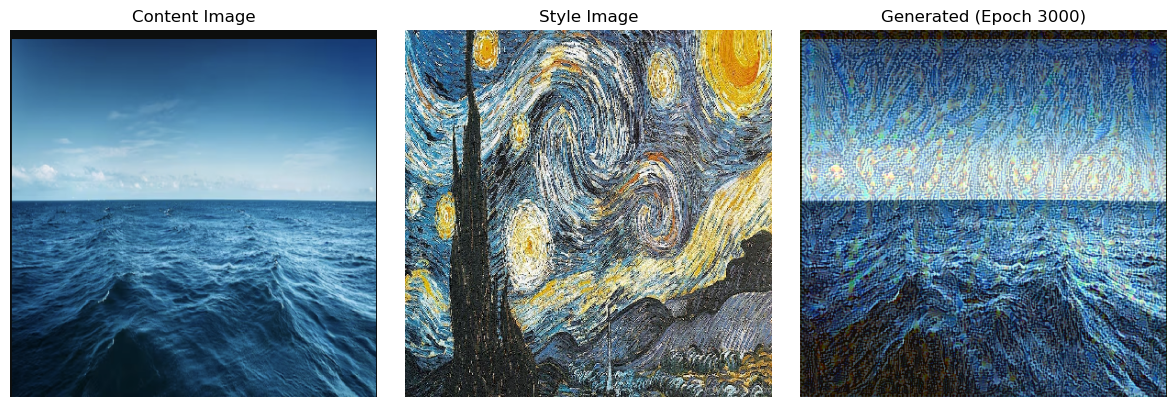

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)  # Fixed LR
!mkdir save_here6
for i in range(20001):
    with tf.GradientTape() as tape:
        generated_vgg = generatedImg
        
        all_outputs = vgg_model_outputs(styleImg)
        a_s, a_s_1, a_s_2, a_s_3, a_s_4, a_c = all_outputs

        all_outputs_gen = vgg_model_outputs(generated_vgg) 
        a_g_s, a_g_s_1, a_g_s_2, a_g_s_3, a_g_s_4, a_g_c = all_outputs_gen
        
        # Calculate style loss over all 5 style layers like second code
        style_layers_target = [a_s, a_s_1, a_s_2, a_s_3, a_s_4]
        style_layers_gen = [a_g_s, a_g_s_1, a_g_s_2, a_g_s_3, a_g_s_4]
        
        style_loss_total = 0
        for target, gen in zip(style_layers_target, style_layers_gen):
            G_s = gram_matrices_vectorized(target)
            G_g = gram_matrices_vectorized(gen)
            style_loss_total += style_cost(G_s, G_g, target)
        style_loss_total /= len(style_layers_target)
        
        content_loss_val = content_cost(a_c, a_g_c)
        
        # Adjust loss weights to approximate second code
        alpha = 8000       # content weight
        beta = 0.1       # style weight
        tv_weight = 3
        
        main_loss = alpha * content_loss_val + beta * style_loss_total
        
        tv_loss = total_variation_loss(generatedImg) * tv_weight
        loss = main_loss + tv_loss
        
        grads = tape.gradient(loss, generatedImg)
        # Removed gradient normalization and clipping to match second code
        
        optimizer.apply_gradients([(grads, generatedImg)])
        
        generatedImg.assign(tf.clip_by_value(generatedImg, 
                                             clip_value_min=-103.939, 
                                             clip_value_max=255-123.68))
        
        # Adjusted display interval to 1000
        if i % 1000 == 0:
            print(f"\nIteration {i}:")
            print(f"Total loss: {loss.numpy():.2e}")
            print(f"  Content loss: {content_loss_val.numpy():.2e}")
            print(f"  Style loss: {style_loss_total.numpy():.2e}")
            print(f"  TV loss: {tv_loss.numpy():.2e}")
            print(f"  Generated img range: [{tf.reduce_min(generatedImg).numpy():.3f}, {tf.reduce_max(generatedImg).numpy():.3f}]")
            
            display_img = vgg_to_display(generatedImg[0])
            print(f"  Display img stats: Min={display_img.min()}, Max={display_img.max()}")
            print(f"  Mean RGB: {display_img.mean(axis=(0,1))}")
            
            plt.figure(figsize=(12, 4))
        
            # Original content
            plt.subplot(1, 3, 1)
            plt.imshow(vgg_to_display(contentImg[0]))
            plt.title('Content Image')
            plt.axis('off')
            
            # Style image
            plt.subplot(1, 3, 2)
            plt.imshow(vgg_to_display(styleImg[0]))
            plt.title('Style Image')
            plt.axis('off')
            
            # Current result
            plt.subplot(1, 3, 3)
            plt.imshow(display_img)
            plt.title(f'Generated (Epoch {i})')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            tf.keras.utils.save_img(
                f'./save_here6/blue_image_{i:05d}.jpeg', 
                display_img, 
                file_format='jpeg'
            )
            

In [ ]:
print("\n🎉 Training Complete!")
final_display = vgg_to_display(generatedImg)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(vgg_to_display(contentImg))
plt.title('Original Content')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(vgg_to_display(styleImg))
plt.title('Style Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(final_display)
plt.title('Generated Result')
plt.axis('off')
plt.suptitle('Neural Style Transfer Results (Modified)', fontsize=16)
plt.tight_layout()
plt.show()

